# Import Dependencies

In [1]:
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
import numpy as np
import itertools
from copy import deepcopy

## Enumerate Search Heuristics

1. Choose row operations in layers, in which we pick the best n/2 disjoint
pairs of rows for row operations before reusing rows in the next layer.
This maximizes circuit parallelism because each row operation will
become a CNOT.

2. Every row operation ideally reduces (or sometimes maintains) the
total number of 1 entries.

3. A row operation is preferred if it leaves the updated row more similar
(by Hamming distance) to another row. This enables a future row
operation to be more effective.

4. Prioritize row operations to remove 1 entries from high-weight columns (high relative numbers of 1 entries). If certain columns are
very high-weight near row-reduction completion, backtrack and
prioritize them sooner.

5. While backtracking to try new choices, prioritize minimizing the
number of operation layers over the number of operations.

6. Column operations do not need to be optimal because they do not
affect the circuit; they only redefine the stabilizer basis.

# Define the Matrix Class

## Weights and Constants

In [12]:
# Empirically discovered pre-weights
# h2_avg = 0.429
# h2_std = 2.115
# h3_avg = -6.0
# h3_std = 2.242
# h4_avg = -2.571
# h4_std = 0.767

h2_wt = 0.8
h3_wt = 0.25
h4_wt = 1.0

h2_avg = 0.002
h2_std = 2.311
h3_avg = -0.193
h3_std = 6.659
h4_avg = -1.801
h4_std = 0.88

## Class Definition 

...for a matrix representation of the CSS code. Rows are qubits and columns are stabilizers or logical operators

In [8]:
from dataclasses import dataclass, field
import numpy as np

@dataclass
class CodeMatrix:

    # ~~ ~~ ~~ Initialization/Utility ~~ ~~ ~~ #

    n_qubits: int
    data: np.ndarray = field(init=False)
    col_labels: list = field(default_factory=list)
    history: list = field(default_factory=list)

    def __post_init__(self):
        self.data = np.zeros((self.n_qubits, 0), dtype=np.uint8)
        self.logical_added = False
        self.logical_col_ids = []

    def __repr__(self):
        labels = [lbl or "-" for lbl in self.col_labels]
        return f"CodeMatrix({self.n_qubits}q, cols={labels})\n{self.data}"

    def __str__(self):
        if self.data.size == 0:
            return f"<Empty CodeMatrix with {self.n_qubits} qubits>"
        display = np.where(self.data == 0, '-', '1')
        header = "     " + "  ".join(f"{lbl:>3}" for lbl in self.col_labels)
        # header = ""
        rows = []
        for i, row in enumerate(display):
            row_str = f"q{i:>2} | " + "  ".join(row)
            rows.append(row_str)
        return f"CodeMatrix ({self.n_qubits} qubits)\n" + header + "\n" + "\n".join(rows)
    
    def copy(self):
        return deepcopy(self)

    # ~~ ~~ ~~ Core functionality ~~ ~~ ~~ #

    def add_column(self, qubits, label=None):
        if self.logical_added: raise Exception("Cannot add a stabilizer column AFTER a logical column")
        col = np.zeros((self.n_qubits, 1), dtype=np.uint8)
        for q in qubits:
            col[q, 0] = 1
        self.data = np.hstack([self.data, col])
        self.col_labels.append(label or f"C{self.data.shape[1]-1}")
        self.history.append(("add_col", label, qubits))

    def add_logical(self, qubits, label=None):
        self.logical_added = True
        col = np.zeros((self.n_qubits, 1), dtype=np.uint8)
        for q in qubits:
            col[q, 0] = 1
        self.data = np.hstack([self.data, col])
        self.col_labels.append(label or f"C{self.data.shape[1]-1}")
        self.history.append(("add_col", label, qubits))
        self.logical_col_ids.append(self.data.shape[1]-1)
    
    def row_op(self, source, target):
        """
        Perform a row operation (source -> target), i.e. add control row to target row mod 2.
        This corresponds to a CNOT with control qubit = control, target qubit = target.
        """
        self.data[target] ^= self.data[source]
        self.history.append(("row_op", source, target))

    def col_op(self, source, target):
        """
        Perform a column operation (source -> target), i.e. add source column to target column mod 2.
        This redefines stabilizers/logicals without changing physical gates.
        """
        self.data[:, target] ^= self.data[:, source]
        self.history.append(("col_op", source, target))

    # ~~ ~~ ~~ Search Utility ~~ ~~ ~~ #

    # Test if the simplification is done
    def valid_matrix(self, M=None):
        M = self if (M == None) else M
        data = np.asarray(M.data)
        n_rows, n_cols = data.shape

        # Logical columns exactly one 1
        logical_cols = list(M.logical_col_ids)
        for c in logical_cols:
            wt = int(data[:, c].sum())
            if wt != 1:
                return False

        # Every row (all columns) at most one 1
        row_sums = data.sum(axis=1)
        for r, s in enumerate(row_sums):
            s = int(s)
            if s > 1:
                return False

        # Every column (all rows) at most one 1
        col_sums = data.sum(axis=0)
        for c, s in enumerate(col_sums):
            s = int(s)
            if s > 1:
                return False
        return True
    
    # Test out a row operation without changing the current matrix
    def try_row_op(self, layer):
        mm = self.copy()
        for control, target in layer:
            mm.row_op(control, target)
        return mm
    
    # Test out a col operation without changing the current matrix
    def try_col_op(self, layer):
        mm = self.copy()
        for control, target in layer:
            mm.col_op(control, target)
        return mm
    
    # Calculate total weight
    def total_weight(self, M=None):
        M = self if (M==None) else M
        return int(M.data.sum())
    
    # Calculate the weight if a row op layer was applied
    def test_weight(self, layer):
        M_after = self.try_row_op(layer)
        return self.total_weight(M_after)

    # ~~ ~~ ~~ Heuristics ~~ ~~ ~~ #

    # H2: total ones reduction
    def score_H2(self, layer):
        M_after = self.try_row_op(layer)
        before = int(self.data.sum())
        after  = int(M_after.data.sum())
        score = after - before
        return (score - h2_avg) / h2_std

    # H3: similarity gain (positive = better)
    def hamming_similarity_gain(self, control, target, M=None):
        M = self if (M==None) else M
        tgt = M.data[target]
        ctrl = M.data[control]
        new_tgt = tgt ^ ctrl
        gain = 0
        for i in range(M.n_qubits):
            if i == target: continue
            current = np.count_nonzero(tgt != M.data[i])
            new = np.count_nonzero(new_tgt != M.data[i])
            gain += (current - new)
        return gain

    # Transform Hamming similarity into heuristic 3 score
    def score_H3(self, layer):
        gain = sum(self.hamming_similarity_gain(c, t) for c, t in layer)
        score = -gain
        return (score - h3_avg) / h3_std

    # H4: heavy-column gain (positive = better)
    def heavy_col_gain(self, control, target, M=None):
        M = self if (M==None) else M
        weights = M.data.sum(axis=0)
        heavy = weights >= np.percentile(weights, 75)

        tgt_before = M.data[target]
        tgt_after  = tgt_before ^ M.data[control]

        removed = np.sum((tgt_before == 1) & (tgt_after == 0) & heavy)
        return removed

    # Transform heavy column gain into heuristic 4 score
    def score_H4(self, layer):
        gain = sum(self.heavy_col_gain(c, t) for c,t in layer)
        score = -gain  # negative = good
        return (score - h4_avg) / h4_std
    
    def total_score(self, layer):
        return (
            h2_wt * self.score_H2(layer) +
            h3_wt * self.score_H3(layer) +
            h4_wt * self.score_H4(layer) 
            )
    
    def debug_score(self, layer):
        h2 = self.score_H2(layer)
        h3 = self.score_H3(layer)
        h4 = self.score_H4(layer)
        total = 1.0*h2 + 0.25*h3 + 0.5*h4
        print(f"H2={h2:.2f}, H3={h3:.2f}, H4={h4:.2f}, total={total:.2f}")

## [7, 1, 3] Color Code Matrix

In [9]:
code = CodeMatrix(7) # Create the [7, 1, 3] code matrix object

code.add_column([0, 1, 2, 3])   # S0 = [Z0, Z1, Z2, Z3]
code.add_column([1, 2, 4, 5])   # S1 = [Z0, Z1, Z2, Z3] 
code.add_column([2, 3, 4, 6])   # S2 = [Z0, Z1, Z2, Z3] 
code.add_logical([0, 1, 5])      # L0 = [Z0, Z1, Z5] 

print("Steps from the paper: \n")

final_code = code.copy()
final_code.row_op(0, 1)
final_code.row_op(3, 2)
final_code.row_op(5, 4)
final_code.row_op(0, 3)
final_code.row_op(2, 5)
final_code.row_op(4, 6)
final_code.row_op(2, 1)
final_code.row_op(4, 3)
final_code.row_op(6, 5)
final_code.col_op(0, 3)
final_code.col_op(2, 3)

print(final_code)
print(final_code.valid_matrix())


Steps from the paper: 

CodeMatrix (7 qubits)
      C0   C1   C2   C3
q 0 | 1  -  -  -
q 1 | -  -  -  -
q 2 | -  1  -  -
q 3 | -  -  -  -
q 4 | -  -  1  -
q 5 | -  -  -  -
q 6 | -  -  -  1
True


# Define the Simplifier Class

## Class Definition

In [43]:
""" This class implements a recursive backtracking (depth-first) search to try to simplify a given code matrix"""

class MatrixSimplifier:
    
    def __init__(self, code_matrix):
        self.base_matrix = code_matrix
        self.current_matrix = self.base_matrix.copy()
        self.layer_history = []

    def apply_gate_layer(self, layer):
        for c, t in layer:
            self.current_matrix.row_op(c, t)
        return
    
    def apply_col_layer(self, layer):
        for c, t in layer:
            self.current_matrix.col_op(c, t)
        return

    # ~~ ~~ ~~ Operational Functions ~~ ~~ ~~ #
        
    # Tells you if a list of qubit pairs is disjoint or not
    def disjoint(self, pairs):
        used = set()
        for c, t in pairs:
            if c in used or t in used:
                return False
            used.add(c); used.add(t)
        return True

    # Create all possible n // 2 disjoint pairs of qubits as gate (row) layers
    def all_layers(self):
        n = self.base_matrix.n_qubits
        all_pairs = [(i, j) for i in range(n) for j in range(n) if i != j]
        k = n // 2
        layers = []
        for combo in itertools.combinations(all_pairs, k):
            if self.disjoint(combo):
                layers.append(combo)
        return layers

    # Generate a list of all valid column operations
    def valid_col_ops(self):
        M = self.base_matrix
        num_cols = M.data.shape[1]
        logical = set(M.logical_col_ids)
        ops = []
        for c in range(num_cols):
            if c in logical:
                continue  # can't use logical as control
            for t in range(num_cols):
                if t != c:
                    ops.append((c, t))
        return ops

    def col_layers(self, N):
        ops = self.valid_col_ops()
        return list(itertools.product(ops, repeat=N))
    
    # Return a ranked list from min to max scores of all possible gate layers
    def rank_gate_layers_on(self, matrix):
        pairs = self.all_layers()
        results = []
        for layer in pairs:
            score = matrix.total_score(layer)
            results.append((score, layer))
        results.sort(key=lambda x: x[0])   # low -> high (change if you want high->low)
        return results

    # Checks to see if any permutation of m column operations can finish your circuit and returns them
    def search_col_ops_on(self, matrix):
        num_cols = matrix.data.shape[1]
        for m in range(num_cols + 1):
            # generate candidate N-length layers
            ops = []
            logical = set(matrix.logical_col_ids)
            for c in range(num_cols):
                if c in logical:
                    continue
                for t in range(num_cols):
                    if t != c:
                        ops.append((c, t))
            for candidate in itertools.product(ops, repeat=m):
                # candidate is a tuple of m (c,t) operations
                mm = matrix.copy()
                for c, t in candidate:
                    mm.col_op(c, t)
                if mm.valid_matrix():   # validate the test matrix itself
                    return candidate
        return None

    
    # ~~ ~~ ~~ Main Recursive-Backtracking Algorithm ~~ ~~ ~~ #

    def simplification(self, max_branch=10, debug=False):

        solved = []
        best_depth = None
        visited = set()   # cache states we've already explored: (data_bytes, tuple(logical_cols), depth_limit)

        # --- serialize matrix state for visited cache ---
        def state_key(matrix):
            return (matrix.data.tobytes(), tuple(matrix.logical_col_ids))

        # --- recursion ---
        def recurse(matrix, depth=0, row_layers_so_far=None):
            nonlocal best_depth
            if row_layers_so_far is None:
                row_layers_so_far = []

            # prune if we already found strictly shorter solution
            if best_depth is not None and depth > best_depth:
                return

            key = state_key(matrix)
            # include depth in visited? we use only structure to avoid revisiting same state
            if key in visited:
                if debug:
                    print(f"Skipping visited state at depth {depth}")
                return
            visited.add(key)

            # 1) try to finish with column ops (on THIS matrix)
            col_layer = self.search_col_ops_on(matrix)
            if col_layer is not None:
                final = matrix.copy()
                for c, t in col_layer:
                    final.col_op(c, t)
                # score the final result (use total_score if you want heuristics 5/6 etc)
                try:
                    score = final.total_score(tuple()) if hasattr(final, "total_score") else 0.0
                except Exception:
                    # fallback: prefer smaller total weight
                    score = -final.total_weight()
                solved.append({
                    "depth": depth,
                    "row_layers": list(row_layers_so_far),
                    "col_layer": list(col_layer),
                    "final_matrix": final,
                    "score": score
                })
                if best_depth is None or depth < best_depth:
                    best_depth = depth
                if debug:
                    print(f"[FOUND] depth={depth}, rows={len(row_layers_so_far)}, col_layer={col_layer}, score={score}")
                # Do not return here; still may want to find other solutions at same depth
                return

            # 2) stop exploring deeper branches if depth would exceed best known
            if best_depth is not None and depth >= best_depth:
                return

            # 3) generate & rank next row layers using the CURRENT matrix (not self.current_matrix)
            ranked = self.rank_gate_layers_on(matrix)
            if not ranked:
                return

            # try top-N branches (max_branch)
            for score, layer in ranked[:max_branch]:
                # apply entire layer to a fresh copy
                next_matrix = matrix.copy()
                for c, t in layer:
                    # row_op might mutate in place or return a new matrix; handle both
                    res = next_matrix.row_op(c, t)
                    if res is not None:
                        # if implementation returns matrix, use it
                        next_matrix = res
                if debug:
                    print(f"Depth {depth} -> trying layer {layer} (score {score:.3f})")

                recurse(next_matrix, depth + 1, row_layers_so_far + [layer])

        # start recursion from a copy of the base/current matrix
        start_matrix = self.current_matrix.copy()
        recurse(start_matrix, depth=0, row_layers_so_far=[])
        # sort solutions by (depth asc, score desc)
        solved.sort(key=lambda s: (s["depth"], -s.get("score", 0.0)))
        if debug:
            print(f"Completed: found {len(solved)} solutions; best_depth={best_depth}")
        return solved



In [44]:
code = CodeMatrix(7) # Create the [7, 1, 3] code matrix object

# Implement the 7 qubit color code
code.add_column([0, 1, 2, 3])   # S0 = [Z0, Z1, Z2, Z3]
code.add_column([1, 2, 4, 5])   # S1 = [Z0, Z1, Z2, Z3] 
code.add_column([2, 3, 4, 6])   # S2 = [Z0, Z1, Z2, Z3] 
code.add_logical([0, 1, 5])      # L0 = [Z0, Z1, Z5] 

# Run the simplifier
smp = MatrixSimplifier(code)
smp.simplification()

[{'depth': 3,
  'row_layers': [((0, 1), (4, 2), (6, 3)),
   ((1, 5), (2, 0), (6, 4)),
   ((0, 5), (1, 4), (2, 3))],
  'col_layer': [],
  'final_matrix': CodeMatrix(7q, cols=['C0', 'C1', 'C2', 'C3'])
  [[0 0 0 1]
   [0 1 0 0]
   [1 0 0 0]
   [0 0 0 0]
   [0 0 0 0]
   [0 0 0 0]
   [0 0 1 0]],
  'score': 2.053144400820591},
 {'depth': 3,
  'row_layers': [((0, 1), (4, 2), (6, 3)),
   ((1, 5), (2, 0), (6, 4)),
   ((0, 5), (2, 3), (4, 1))],
  'col_layer': [],
  'final_matrix': CodeMatrix(7q, cols=['C0', 'C1', 'C2', 'C3'])
  [[0 0 0 1]
   [0 0 0 0]
   [1 0 0 0]
   [0 0 0 0]
   [0 1 0 0]
   [0 0 0 0]
   [0 0 1 0]],
  'score': 2.053144400820591},
 {'depth': 3,
  'row_layers': [((0, 1), (4, 2), (6, 3)),
   ((1, 5), (2, 0), (6, 4)),
   ((1, 4), (2, 3), (5, 0))],
  'col_layer': [],
  'final_matrix': CodeMatrix(7q, cols=['C0', 'C1', 'C2', 'C3'])
  [[0 0 0 0]
   [0 1 0 0]
   [1 0 0 0]
   [0 0 0 0]
   [0 0 0 0]
   [0 0 0 1]
   [0 0 1 0]],
  'score': 2.053144400820591},
 {'depth': 3,
  'row_layers': [

# Study the Heuristic Weights

## Balance the Initial Weights

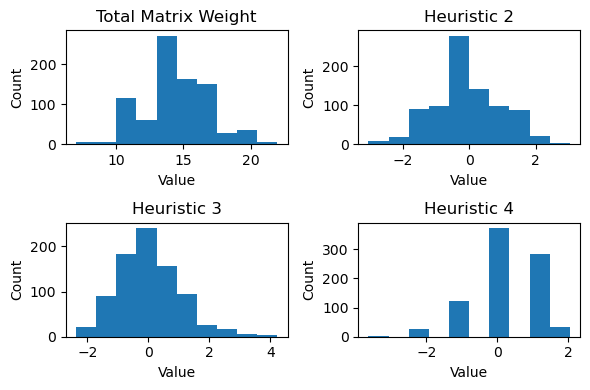

Average score on Heuristic 2 : 0.000 ; Standard Deviation: 1.000
Average score on Heuristic 3 : 0.000 ; Standard Deviation: 1.000
Average score on Heuristic 4 : -0.000 ; Standard Deviation: 0.999


In [11]:
smp = MatrixSimplifier(code)

pairs = smp.all_layers()
total_weight = []
h2 = []
h3 = []
h4 = []

for layer in pairs:
    smp.current_matrix = smp.base_matrix    # Revert to initial marix
    smp.apply_gate_layer(layer)             # Apply this layer 
    m = smp.current_matrix                  # Rename the matrix
    total_weight.append(m.total_weight())   # Score the total weight
    h2.append(m.score_H2(layer))            # Score heuristic 2
    h3.append(m.score_H3(layer))            # Score heuristic 3
    h4.append(m.score_H4(layer))            # Score heuristic 4

h2 = np.array(h2)
h3 = np.array(h3)
h4 = np.array(h4)

fig, axes = plt.subplots(2, 2, figsize=(6, 4))

axes[0, 0].hist(total_weight, bins=10)
axes[0, 0].set_title("Total Matrix Weight")

axes[0, 1].hist(h2, bins=10)
axes[0, 1].set_title("Heuristic 2")

axes[1, 0].hist(h3, bins=10)
axes[1, 0].set_title("Heuristic 3")

axes[1, 1].hist(h4, bins=10)
axes[1, 1].set_title("Heuristic 4")

for ax in axes.flat:
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")

fig.tight_layout()
plt.show()

h2_avg_2 = np.average(h2)
h3_avg_2 = np.average(h3)
h4_avg_2 = np.average(h4)
h2_std_2 = np.std(h2)
h3_std_2 = np.std(h3)
h4_std_2 = np.std(h4)

print(f"Average score on Heuristic 2 : {h2_avg_2:.3f} ; Standard Deviation: {h2_std_2:.3f}")
print(f"Average score on Heuristic 3 : {h3_avg_2:.3f} ; Standard Deviation: {h3_std_2:.3f}")
print(f"Average score on Heuristic 4 : {h4_avg_2:.3f} ; Standard Deviation: {h4_std_2:.3f}")

In [ ]:
code = CodeMatrix(7) # Create the [7, 1, 3] code matrix object

# Implement the 7 qubit color code
code.add_column([0, 1, 2, 3])   # S0 = [Z0, Z1, Z2, Z3]
code.add_column([1, 2, 4, 5])   # S1 = [Z0, Z1, Z2, Z3] 
code.add_column([2, 3, 4, 6])   # S2 = [Z0, Z1, Z2, Z3] 
code.add_logical([0, 1, 5])     # L0 = [Z0, Z1, Z5] 